# Project 3: EEG Classification Model

## Data Preprocessing

Since the dataset is large, the data is processed in chunks and the below mentioned modules are used to perform data extraction for ease of use and readability.

Annotations can be found after every step that explains the process better. 

Data preprocessing activity is very minimal since the data is clean i.e there are no null values in any of the fields that need to be handled or any datatypes that need to be converted. 

## Feature Extraction

In [2]:
#extractFeature.py

import pyedflib
import numpy as np
import tqdm
import mne
from scipy.signal import welch,stft
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import euclidean

def extract_basic_features(signal):
    signal = (signal - np.mean(signal)) / np.std(signal)
    mean = np.mean(signal)
    std = np.std(signal)
    sample_entropy = np.log(np.std(np.diff(signal)))
    fuzzy_entropy = -np.log(euclidean(signal[:-1], signal[1:]) / len(signal))
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return [mean, std, sample_entropy, fuzzy_entropy, skewness, kurt]

def extract_advanced_features(data, fs, window_length_sec=3):
    
    f, t, Zxx = stft(data, fs, nperseg=window_length_sec*fs)
    
    power = np.mean(np.abs(Zxx)**2, axis=1) 

    return power

def preprocess_and_extract_features_mne_with_timestamps(file_name):
    
    raw = mne.io.read_raw_edf(file_name, preload=True)

    raw.filter(1., 50., fir_design='firwin')

    raw.pick_types(meg=False, eeg=True, eog=False)

    
    window_length = 3  
    sfreq = raw.info['sfreq'] 
    window_samples = int(window_length * sfreq)

    features_with_timestamps = []

    for start in range(0, len(raw.times), window_samples):
        end = start + window_samples
        if end > len(raw.times):
            break

        window_data, times = raw[:, start:end]
        window_data = np.squeeze(window_data)

        
        timestamp = raw.times[start]

        for channel_data in window_data:
            basic_features = extract_basic_features(channel_data)
            advanced_features = extract_advanced_features(channel_data, sfreq)
            combined_features = np.concatenate([[timestamp], basic_features, advanced_features])
            features_with_timestamps.append(combined_features)

    return np.array(features_with_timestamps)

#preprocess_and_extract_features_mne_with_timestamps("smaller_dataset/chb01/chb01_03.edf")

The function **extract_basic_features** extracts time-domain features such as Mean, Standard Deviation, Entropy, Skewness and Kurtosis. The function **extract_advanced_features** extracts advanced features by passing the frequency values and returns the power. The function **preprocess_and_extract_features_mne_with_timestamps** extracts the time-domain and advanced features for every channel based on the timestamps i.e the duration in which the signals were recorded.

In [3]:
#extractTarget.py

import os
def extractTarget(summary_file_path, edf_file_path):
    edf_file_name = os.path.basename(edf_file_path)
    
    seizure_start_time = None
    seizure_end_time = None
    
    with open(summary_file_path, 'r') as file:
        lines = file.readlines()
    
    found = False
    
    for line in lines:
        if "File Name: " + edf_file_name in line:
            found = True
        if found:
            if "Number of Seizures in File: 0" in line:
                return None, None  
            if "Seizure Start Time:" in line:
                seizure_start_time = int(line.split(": ")[1].split(" ")[0])
            if "Seizure End Time:" in line:
                seizure_end_time = int(line.split(": ")[1].split(" ")[0])
                break  
    return seizure_start_time, seizure_end_time

The function **extractTarget** reads the summary files to analyze whether or not a Seizure occurred during the recording. 

In [10]:
#loadData.py

import glob
import os.path
import numpy as np
#from src.data.extractFeture import preprocess_and_extract_features_mne_with_timestamps
#from src.data.extractTarget import extractTarget

def extract_data_and_labels(edf_file_path, summary_file_path):

    X = preprocess_and_extract_features_mne_with_timestamps(edf_file_path)
    seizure_start_time, seizure_end_time = extractTarget(summary_file_path, edf_file_path)
    #y = np.array([1 if seizure_start_time <= row[0] <= seizure_end_time else 0 for row in X])

    #y = 0
    
    seizure_start_time, seizure_end_time = extractTarget(summary_file_path, edf_file_path)
    if not seizure_start_time and not seizure_end_time:
        seizure_start_time = -1
        seizure_end_time = 100000000000
    y = np.array([1 if seizure_start_time <= row[0] <= seizure_end_time else 0 for row in X])
    
    X = X[:,1:]
    return X,y

def load_data(base_path):
    
    all_X = []
    all_y = []

    # Get a list of all subdirectories (assuming they follow the format "chb{:02d}")
    subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d)) and d.startswith("chb")]
    print(subject_dirs)

    count=0
    for subject_dir in subject_dirs:
        count += 1
        if(count <=2):
            subject_id = int(subject_dir[3:])  # Extract subject ID from the directory name
            edf_file_path = sorted(glob.glob(os.path.join(base_path, subject_dir, "*.edf")))
            summary_file_path = os.path.join(base_path, subject_dir, "{}-summary.txt".format(subject_dir))

            print('subject_dir: ',subject_dir)
            print('subject_id: ',subject_id)
            print('edf_file_path: ',edf_file_path)
            print('summary_file_path: ',summary_file_path)
            
            #flag = 0
            for edf_file_path in edf_file_path:
                X, y = extract_data_and_labels(edf_file_path, summary_file_path)
                all_X.append(X)
                all_y.append(y)

    return all_X, all_y

The function **load_data** loads data from all folders starting with "chb". This utilizes the structure of the dataset shards and captures both the signal data as well as the seizure data. 

In [11]:
#call to load data

import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
#from src.data.loaddata import load_data

warnings.filterwarnings("ignore")

#subject_id = 1
base_path = "./smaller_datasets/" #"data"
all_X,all_y = load_data(base_path)

X = np.vstack(all_X)
y = np.concatenate(all_y)


['chb01', 'chb02', 'chb03', 'chb04']
subject_dir:  chb01
subject_id:  1
edf_file_path:  ['./smaller_datasets/chb01\\chb01_01.edf', './smaller_datasets/chb01\\chb01_02.edf', './smaller_datasets/chb01\\chb01_03.edf', './smaller_datasets/chb01\\chb01_04.edf', './smaller_datasets/chb01\\chb01_05.edf', './smaller_datasets/chb01\\chb01_06.edf', './smaller_datasets/chb01\\chb01_07.edf', './smaller_datasets/chb01\\chb01_08.edf', './smaller_datasets/chb01\\chb01_09.edf', './smaller_datasets/chb01\\chb01_10.edf']
summary_file_path:  ./smaller_datasets/chb01\chb01-summary.txt
Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb01\chb01_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


subject_dir:  chb02
subject_id:  2
edf_file_path:  ['./smaller_datasets/chb02\\chb02_01.edf', './smaller_datasets/chb02\\chb02_02.edf', './smaller_datasets/chb02\\chb02_03.edf', './smaller_datasets/chb02\\chb02_04.edf', './smaller_datasets/chb02\\chb02_05.edf', './smaller_datasets/chb02\\chb02_06.edf', './smaller_datasets/chb02\\chb02_07.edf', './smaller_datasets/chb02\\chb02_08.edf', './smaller_datasets/chb02\\chb02_09.edf', './smaller_datasets/chb02\\chb02_10.edf']
summary_file_path:  ./smaller_datasets/chb02\chb02-summary.txt
Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb02\chb02_10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


## Strategy to avoid overfitting

In [12]:
# Apply SMOTE for oversampling
from sklearn.preprocessing import StandardScaler

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardize data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

We are using SMOTE which implements random sampling to ensure that the model does not overfit the data.

## Model Selection

We are implementing Decision Tree Classifier and CNN, based on the model performance, we can choose the one that performs the best. 

### Decision Tree Classifier

In [10]:
#train

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)


clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)


clf_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", clf_accuracy)


clf_f1 = f1_score(y_test, y_pred)
print(f"Decision Tree F1 Score: {clf_f1}")

Decision Tree Accuracy: 0.9251638674047961
Decision Tree F1 Score: 0.9241409296574589


### CNN Model

In [19]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras import layers

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)

# Reshape data for 1D CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Convert predictions to 1D array
y_test_1d = y_test.flatten()
y_pred_1d = y_pred.flatten()

# Calculate accuracy and F1 score
cnn_accuracy = accuracy_score(y_test_1d, y_pred_1d)
cnn_f1 = f1_score(y_test_1d, y_pred_1d)

print("Accuracy:", cnn_accuracy)
print("F1 Score:", cnn_f1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t

### Visualization

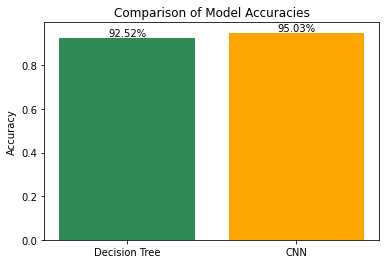

In [26]:
import matplotlib.pyplot as plt
# Visualize Accuracies with Percentages
labels = ['Decision Tree', 'CNN']
accuracies = [0.9251638674047961, cnn_accuracy]

fig, ax = plt.subplots()
bars = ax.bar(labels, accuracies, color=['seagreen', 'orange'])

# Add percentages on top of the bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.2%}', ha='center', va='bottom')

plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

In [30]:
import mne
import matplotlib.pyplot as plt

# Specify the file paths
# with seizure
file_path_1 = "smaller_datasets/chb03/chb03_01.edf"
# without seizure
file_path_2 = "smaller_datasets/chb03/chb03_05.edf"

# Read the raw EEG data for both files
raw_1 = mne.io.read_raw_edf(file_path_1)
raw_2 = mne.io.read_raw_edf(file_path_2)

Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb03\chb03_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\Pooja\Desktop\Fall '23\FDA IE 6400\Projects\Group5_Project3\smaller_datasets\chb03\chb03_05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Effective window size : 1.000 (s)
Using matplotlib as 2D backend.


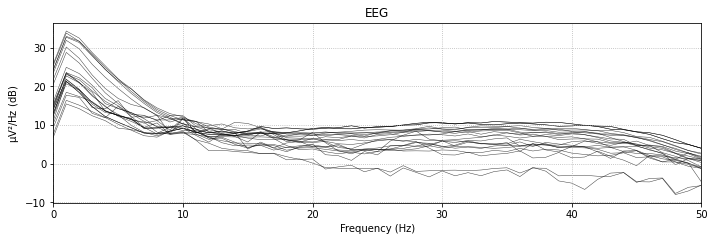

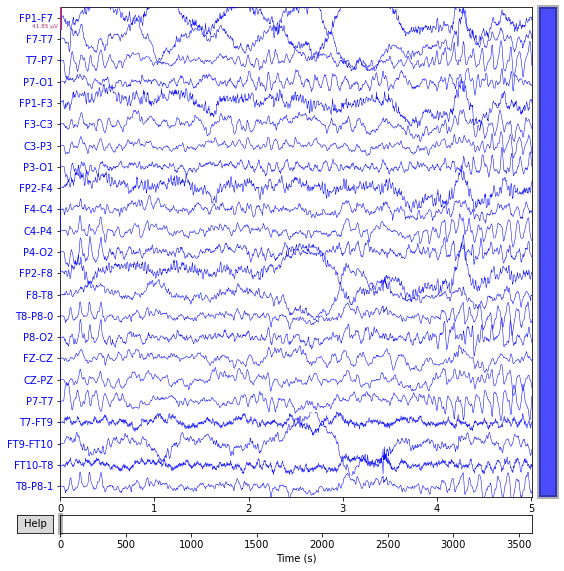

In [31]:
# Plot the power spectral density without amplitude (frequency plot) with a specific color
psd_fig1 = raw_1.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False, color='green')
#psd_fig.set_title('Power Spectral Density')

# Plot the raw EEG data with a different color for each channel
raw_1.plot(duration=5, n_channels=30, color='blue', scalings='auto')
plt.show()

Effective window size : 1.000 (s)


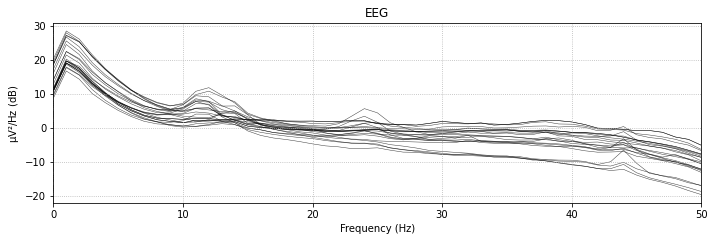

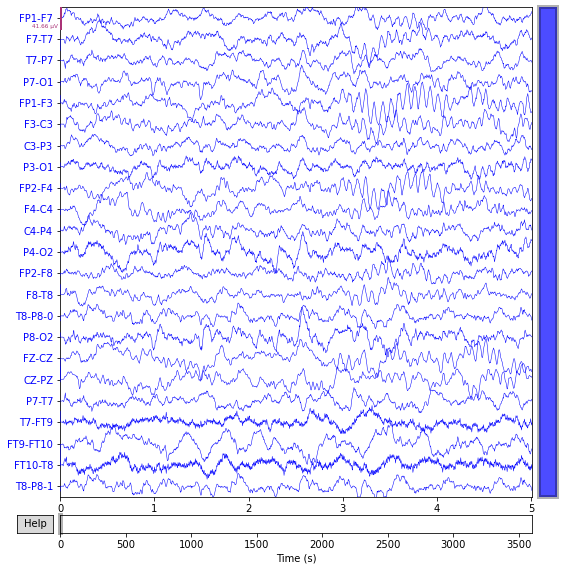

In [32]:
# Plot the power spectral density without amplitude (frequency plot) with a specific color
psd_fig2 = raw_2.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False, color='green')
#psd_fig.set_title('EEG(without seizure)')

# Plot the raw EEG data with a different color for each channel
raw_2.plot(duration=5, n_channels=30, color='blue', scalings='auto')
plt.show()